# GR00T Inference

This tutorial shows how to use the GR00T inference model to predict the actions from the observations, given a test dataset.

In [ ]:
import os
import torch
import gr00t

from gr00t.data.dataset import LeRobotSingleDataset
from gr00t.model.policy import Gr00tPolicy

In [8]:
# change the following paths
MODEL_PATH = "nvidia/GR00T-N1-2B"

# REPO_PATH is the path of the pip install gr00t repo and one level up
REPO_PATH = os.path.dirname(os.path.dirname(gr00t.__file__))
DATASET_PATH = os.path.join(REPO_PATH, "demo_data/robot_sim.PickNPlace")
EMBODIMENT_TAG = "gr1"

device = "cuda" if torch.cuda.is_available() else "cpu"

## Loading Pretrained Policy

Policy Model is loaded just like any other huggingface model.

There are 2 new concepts here in the GR00T model:
 - modality config: This defines the keys in the dictionary used by the model. (e.g. `action`, `state`, `annotation`, `video`)
 - modality_transform: A sequence of transform which are used during dataloading

In [ ]:
from gr00t.experiment.data_config import DATA_CONFIG_MAP


data_config = DATA_CONFIG_MAP["gr1_arms_only"]
modality_config = data_config.modality_config()
modality_transform = data_config.transform()

policy = Gr00tPolicy(
    model_path=MODEL_PATH,
    embodiment_tag=EMBODIMENT_TAG,
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)

# print out the policy model architecture
print(policy.model)

## Loading dataset

First this requires user to check which embodiment tags are used to pretrained the `Gr00tPolicy` pretrained models.

In [4]:
import numpy as np

modality_config = policy.modality_config

print(modality_config.keys())

for key, value in modality_config.items():
    if isinstance(value, np.ndarray):
        print(key, value.shape)
    else:
        print(key, value)


dict_keys(['video', 'state', 'action', 'language'])
video delta_indices=[0] modality_keys=['video.ego_view']
state delta_indices=[0] modality_keys=['state.left_arm', 'state.right_arm', 'state.left_hand', 'state.right_hand']
action delta_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] modality_keys=['action.left_arm', 'action.right_arm', 'action.left_hand', 'action.right_hand']
language delta_indices=[0] modality_keys=['annotation.human.action.task_description']


In [5]:
# Create the dataset
dataset = LeRobotSingleDataset(
    dataset_path=DATASET_PATH,
    modality_configs=modality_config,
    video_backend="decord",
    video_backend_kwargs=None,
    transforms=None,  # We'll handle transforms separately through the policy
    embodiment_tag=EMBODIMENT_TAG,
)

Initialized dataset robot_sim.PickNPlace with gr1


Let's print out a single data and visualize it

In [6]:
import numpy as np

step_data = dataset[0]

print(step_data)

print("\n\n ====================================")
for key, value in step_data.items():
    if isinstance(value, np.ndarray):
        print(key, value.shape)
    else:
        print(key, value)


{'video.ego_view': array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]]], dtype=uint8), 'state.left_arm': array([[-0.01147083,  0.12207967,  0.04229397, -2.1       , -0.01441445,
        -0.03013532, -0.00384387]]), 'state.r

Let's plot just the "right hand" state and action data and see how it looks like. Also show the images of the right hand state.

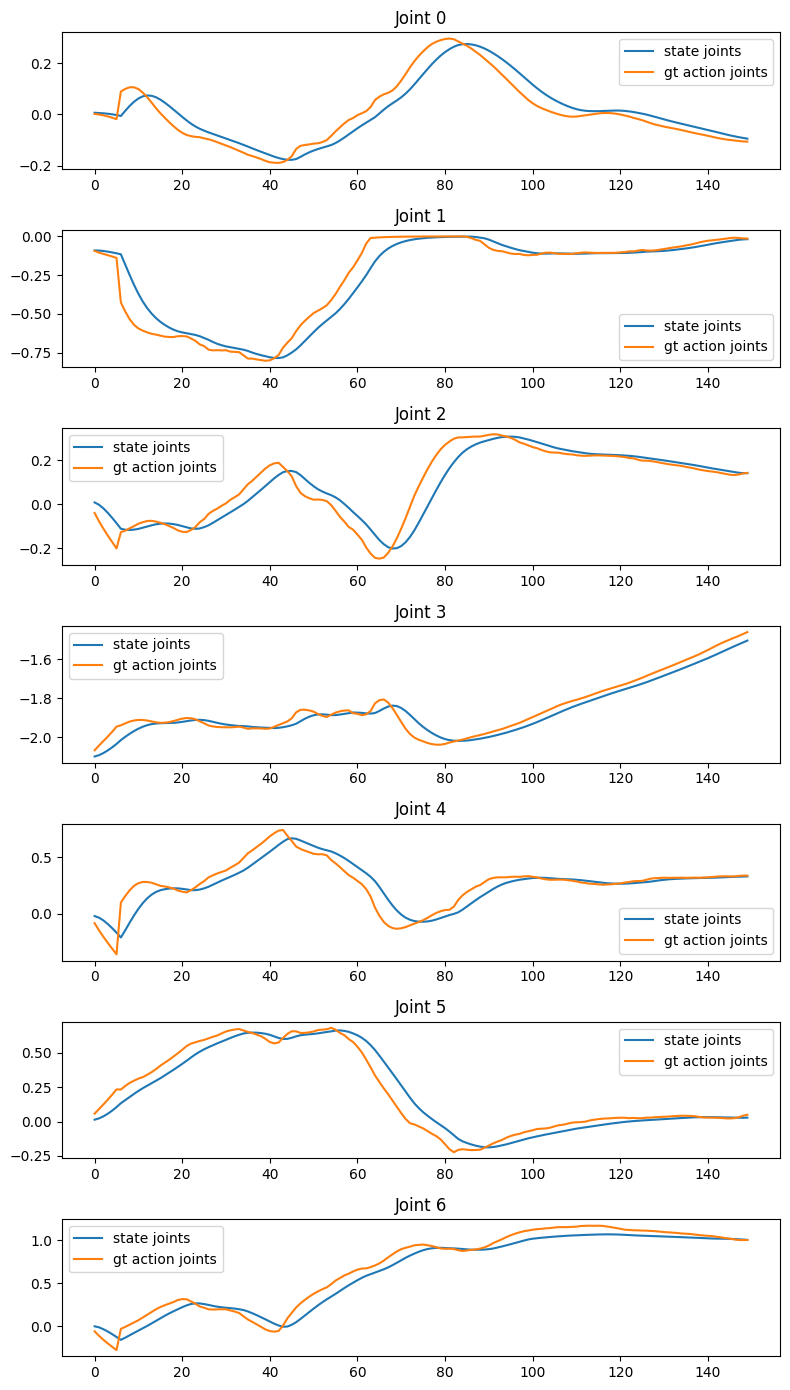

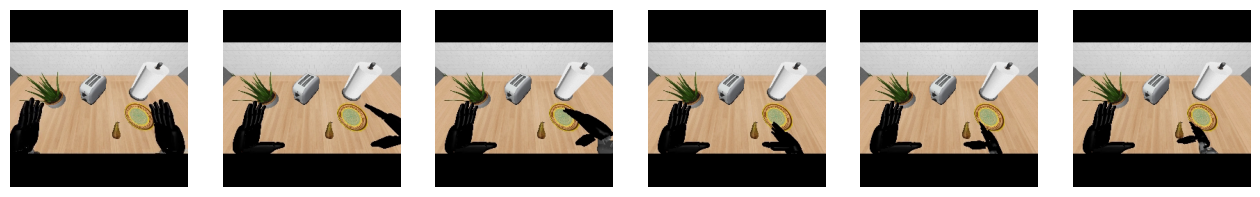

In [7]:
import matplotlib.pyplot as plt

traj_id = 0
max_steps = 150

state_joints_across_time = []
gt_action_joints_across_time = []
images = []

sample_images = 6

for step_count in range(max_steps):
    data_point = dataset.get_step_data(traj_id, step_count)
    state_joints = data_point["state.right_arm"][0]
    gt_action_joints = data_point["action.right_arm"][0]
    
   
    state_joints_across_time.append(state_joints)
    gt_action_joints_across_time.append(gt_action_joints)

    # We can also get the image data
    if step_count % (max_steps // sample_images) == 0:
        image = data_point["video.ego_view"][0]
        images.append(image)

# Size is (max_steps, num_joints == 7)
state_joints_across_time = np.array(state_joints_across_time)
gt_action_joints_across_time = np.array(gt_action_joints_across_time)


# Plot the joint angles across time
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(8, 2*7))

for i, ax in enumerate(axes):
    ax.plot(state_joints_across_time[:, i], label="state joints")
    ax.plot(gt_action_joints_across_time[:, i], label="gt action joints")
    ax.set_title(f"Joint {i}")
    ax.legend()

plt.tight_layout()
plt.show()


# Plot the images in a row
fig, axes = plt.subplots(nrows=1, ncols=sample_images, figsize=(16, 4))

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis("off")
    

Now we can run the policy from the pretrained checkpoint.

In [12]:
predicted_action = policy.get_action(step_data)
for key, value in predicted_action.items():
    print(key, value.shape)

The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


action.left_arm (16, 7)
action.right_arm (16, 7)
action.left_hand (16, 6)
action.right_hand (16, 6)


### Understanding the Action Output

Each joint in the action output has a shape of (16, N) where N is the degree of freedom for the joint.
- 16 represents the action horizon (predictions for timesteps t, t+1, t+2, ..., t+15)

For each arm (left and right):
- 7 arm joints:
  - Shoulder pitch
  - Shoulder roll
  - Shoulder yaw
  - Elbow pitch
  - Wrist yaw
  - Wrist roll
  - Wrist pitch

For each hand (left and right):
- 6 finger joints:
  - Little finger
  - Ring finger
  - Middle finger
  - Index finger
  - Thumb rotation
  - Thumb bending

For the waist
- 3 joints:
  - torso waist yaw
  - torso waist pitch
  - torso waist roll
